In [94]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import numpy as np
import pandas as pd
import pickle
import tflscripts
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
# import seaborn as sns; sns.set(style='whitegrid')

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')
df = df.replace(np.inf, np.nan)
df_mites = df.loc[(df.source_device_type == 'Mite') & (df.target_device_type == 'Mite')]

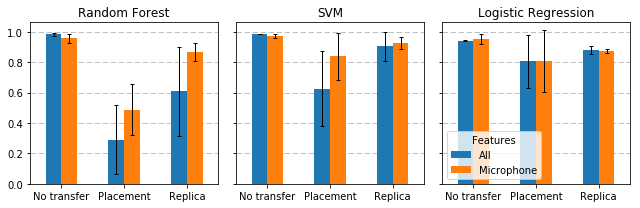

In [20]:
plt.rcParams["figure.figsize"] = (9, 3)

def bar_plot(df_plot, groupby, label=None, room=None, source_placement=None, target_placement=None, features=None, classifier=None, values='f1', ax=None):
    if label is not None:
        df_plot = df_plot.loc[df_plot.label == label]
    if room is not None:
        df_plot = df_plot.loc[(df_plot.source_room == room) & (df_plot.target_room == room)]
    if source_placement is not None:
        df_plot = df_plot.loc[df_plot.source_placement == source_placement]
    if target_placement is not None:
        df_plot = df_plot.loc[df_plot.target_placement == target_placement]
    if classifier is not None:
        df_plot = df_plot.loc[df_plot.classifier == classifier]
    if features is not None:
        df_plot = df_plot.loc[df_plot.features_name == features]

    by_classifiers = df_plot.groupby(groupby)[values].mean().reset_index()
    by_classifiers = by_classifiers.pivot_table(columns=groupby[0], index=groupby[1], values=values)
    errors = df_plot.groupby(groupby)[values].std().reset_index()
    errors = errors.pivot_table(columns=groupby[0], index=groupby[1], values=values)
    ax = by_classifiers.plot.bar(yerr=errors,
                                 ax=ax,
                                 error_kw=dict(lw=1, capsize=2, capthick=1))
    matplotlib.pyplot.sca(ax)
    ax.set_axisbelow(True)
    ax.yaxis.grid(linestyle='dashed',)

f, axes = plt.subplots(1, 3, sharex=False, sharey=True)

df_plot = df_mites.loc[df_mites.features_name.isin(['All', 'Microphone'])].copy()
df_plot = df_plot.replace('Same device type in same place', 'Replica')
df_plot = df_plot.replace('Same device type in different place', 'Placement')
df_plot = df_plot.replace('Same device in different place', 'Placement')
df_plot = df_plot.rename(columns={'features_name': 'Features'})

bar_plot(df_plot=df_plot,
         label='Dishes',
         room='synergy',
#          features='All',
         source_placement='Coffee',
         classifier='RandomForestClassifier',
         ax=axes[0],
         groupby=['Features', 'type_of_transfer'])
plt.title('Random Forest')
plt.xlabel('')
plt.xticks(rotation=0)

bar_plot(df_plot=df_plot,
         label='Dishes',
         room='synergy',
#          features='All',
         source_placement='Coffee',
         classifier='SVM',
         ax=axes[1],
         groupby=['Features', 'type_of_transfer'])
plt.title('SVM')
plt.xlabel('')
plt.xticks(rotation=0)

bar_plot(df_plot=df_plot,
         label='Dishes',
         room='synergy',
#          features='All',
         source_placement='Coffee',
         classifier='LogisticRegression',
         ax=axes[2],
         groupby=['Features', 'type_of_transfer'])
plt.title('Logistic Regression')
plt.xlabel('')
plt.xticks(rotation=0)

axes[0].legend_.remove()
axes[1].legend_.remove()

plt.tight_layout()

plt.savefig('../plots/classifier_performance_by_features_and_transfer_type.pdf')
plt.show()

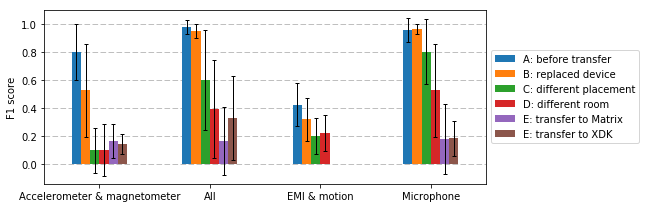

In [28]:
plt.rcParams["figure.figsize"] = (7, 3)

def to_transfer_category(row):
    type_of_transfer = row['type_of_transfer']
    if type_of_transfer == 'Different device in same place':
        if row['target_device_type'] == 'Matrix':
            return 'E: transfer to Matrix'
        else:
            return 'E: transfer to XDK'
    else:
        return {
            'No transfer': 'A: before transfer',
            'Same device type in same place': 'B: replaced device',
            'Same device type in different place': 'C: different placement',
            'Same device type across spaces': 'D: different room',
            'Same device across spaces': 'D: different room'
        }[type_of_transfer]

df_plot = df.loc[df.source_device_type == 'Mite'].copy()
df_plot = df_plot.loc[df_plot.type_of_transfer.isin([
    'No transfer',
    'Same device type in same place',
    'Different device in same place', 'Same device type in different place',
    'Same device across spaces', 'Same device type across spaces'
])]

df_plot = df_plot.loc[df_plot.features_name.isin([
    'All',
    'Accelerometer & magnetometer',
    'Microphone',
    'EMI & motion'
])]

df_plot['transfer_category'] = [to_transfer_category(row) for i, row in df_plot.iterrows()]
df_plot = df_plot.loc[df_plot.label.isin([
    'Alarm', 'Blender running', 'Vacuum cleaning',
    'Chopping food', 'Dishes', 'Microwave'
])]

bar_plot(df_plot=df_plot,
#          label='Dishes',
         classifier='SVM',
#          room='synergy',
         source_placement='Coffee',
         values='f1',
         groupby=['transfer_category', 'features_name'])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('F1 score')
plt.tight_layout()

plt.savefig('../plots/feature_performance_by_transfer.pdf')
plt.show()

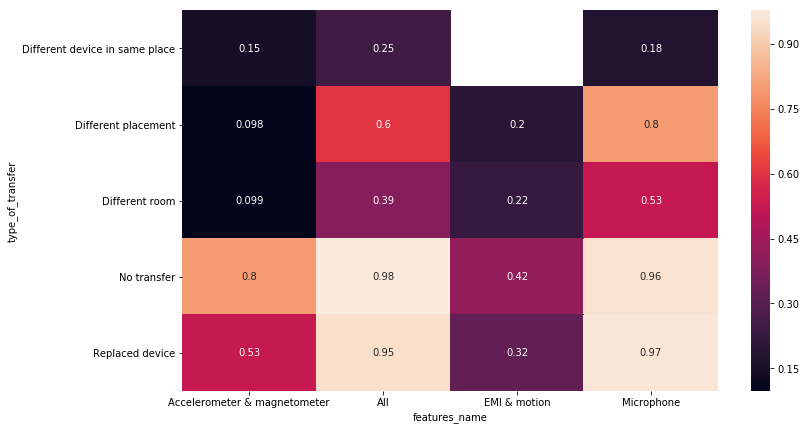

In [98]:
import seaborn

df_plot = df.loc[df.source_device_type == 'Mite']
df_plot = df_plot.loc[df_plot.type_of_transfer.isin([
    'No transfer',
    'Same device type in same place',
    'Different device in same place', 'Same device type in different place',
    'Same device across spaces', 'Same device type across spaces'
])]

df_plot = df_plot.loc[df_plot.features_name.isin([
    'All',
    'Accelerometer & magnetometer',
    'Microphone',
    'EMI & motion'
])]

df_plot = df_plot.replace('Same device type in same place', 'Replaced device')
df_plot = df_plot.replace('Same device type across spaces', 'Different room')
df_plot = df_plot.replace('Same device across spaces', 'Different room')
df_plot = df_plot.replace('Same device type in different place', 'Different placement')
df_plot = df_plot.loc[df_plot.label.isin([
    'Alarm', 'Blender running', 'Vacuum cleaning',
    'Chopping food', 'Dishes', 'Microwave'
])]

df_plot = df_plot.loc[df_plot.classifier == 'SVM']
# df_plot = df_plot.loc[df_plot.label == 'Dishes']
df_plot = df_plot.loc[df_plot.source_placement == 'Coffee']
values = 'f1'

plot_df = df_plot.groupby(['type_of_transfer', 'features_name'])[values].mean().reset_index()

seaborn.heatmap(
    plot_df.pivot_table(index='type_of_transfer', columns='features_name', values=values),
    annot=True
)